# Notes

This notebook is an example of a PRE-PROCESSING pipeline for satellite images with LAI data.
It is not meant to be run as a script, but rather to be used as a reference for how to use the preprocessing functions.

**IMPORTANT** This notebook assumes one has stored a series of *unpacked* RAS and RHD files in the VISTA format containing 
- The Leaf Area Index (LAI) values as a tensor of images over time.
- Information of the datetimes and the coordinates of the images. 

The VISTA format is not publicly available, but the functions in this notebook can be used as a reference for how to preprocess satellite images in general.

*Example scenario*: We have downloaded the RAS and RHD files containing the LAI values for a sentinel-2 tile (~12k by 12k image) over the span of 2020. We want to preprocess this data into timeseries for further analysis.

*Author*: Jens d'Hondt (TU Eindhoven)

In [1]:
# General imports
import os
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import sys
import seaborn as sns
from eolearn.core import EOPatch

# 0 Unpacking the data

This step unapacks a RAS-RHD file pair with LAI values into a series of .npy files, named by the date of the image.
(e.g. `2020_1_1.npy`, `2020_1_2.npy`, ...) 
The unpacking can be done using the `unpack_vista_unzipped` function in `stelar_spatiotemporal/preprocessing/vista_preprocessing.py`, as shown below.

**Assumptions**:
- One has downloaded and unzipped the RAS and RHD files to be processed.
- The RAS files can contain multiple images, each with a different date, month or year.

**Process**:
The function `unpack_vista_unzipped` will do the following:
1. Extract the images from the RAS file and store them in a series of .npy files named by the date of the individual image, based on the accompanied RHD file.

In [116]:
# Set minio credentials
os.environ["MINIO_ENDPOINT_URL"] = "http://localhost:9000"
os.environ["MINIO_ACCESS_KEY"] = "minioadmin"
os.environ["MINIO_SECRET_KEY"] = "minioadmin"

S3DATADIR = "s3://stelar-spatiotemporal/LAI"
LOCAL_DATADIR = "/home/jens/ownCloud/Documents/3.Werk/0.TUe_Research/0.STELAR/0.VISTA/VISTA_workbench/data/pipeline_example"
TMPDIR = LOCAL_DATADIR + "/tmp"

os.makedirs(TMPDIR, exist_ok=True)

In [117]:
from sentinelhub import CRS
from stelar_spatiotemporal.preprocessing.vista_preprocessing import unpack_vista_unzipped

ras_path = os.path.join(LOCAL_DATADIR, 'LAI_ras', "30TYQ_LAI_2020.RAS")
rhd_path = os.path.join(LOCAL_DATADIR, 'LAI_ras', "30TYQ_LAI_2020.RHD")

outdir = os.path.join(TMPDIR, "npys")

# Unpacks RAS and RHD files into numpy arrays
unpack_vista_unzipped(ras_path, rhd_path, outdir, crs=CRS(32630))

Unpacking 87 images from /home/jens/ownCloud/Documents/3.Werk/0.TUe_Research/0.STELAR/0.VISTA/VISTA_workbench/data/pipeline_example/LAI_ras/30TYQ_LAI_2020.RAS


# Option A: Batch processing the data

## 1 Combining images to eopatches

In this step we will combine the individual LAI images into a tensor, or package of images. 

**Assumptions**:
- One has stored the .npy files containing the images in a folder `$DATADIR` following the structure `DATADIR/npys/{date}.npy`.

**Process**:
The function `combine_bands` will do the following:
1. Partition the .npy files into a series of EOPatches, each containing a tensor of images, the corresponding datetimes and bounding box.

In [118]:
from stelar_spatiotemporal.preprocessing.preprocessing import combine_npys_into_eopatches, max_partition_size
from stelar_spatiotemporal.lib import load_bbox

npy_dir = os.path.join(TMPDIR, "npys")

npy_paths = glob.glob(os.path.join(npy_dir,"*.npy"))
max_partition_size = max_partition_size(npy_paths[0], MAX_RAM=int(4 * 1e9))

bbox = load_bbox(os.path.join(npy_dir, "bbox.pkl"))

outpath = os.path.join(LOCAL_DATADIR, "lai_eopatch")
combine_npys_into_eopatches(npy_paths=npy_paths, 
                            outpath=outpath,
                            feature_name="LAI",
                            bbox=bbox,
                            partition_size=max_partition_size,
                            delete_after=True,
                            )

Processing 5 partitions of 19 dates each


KeyboardInterrupt: 

In [9]:
path = "/home/jens/ownCloud/Documents/3.Werk/0.TUe_Research/0.STELAR/0.VISTA/VISTA_workbench/data/pipeline_example/patchlets/patchlet_0_0"

eop = EOPatch.load(path)

eop

EOPatch(
  data: {
    LAI: numpy.ndarray(shape=(87, 1128, 1128, 1), dtype=int16)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((704855.0, 4983865.0), (716135.0, 4995145.0)), crs=CRS('32630'))
  timestamp: [datetime.datetime(2020, 1, 6, 0, 0), ..., datetime.datetime(2020, 12, 29, 0, 0)], length=87
)

# 2 LAI to CSV

In this step we will convert the LAI values to a timeseries of LAI values for each pixel OR field (extracted in the segmentation pipeline).
The conversion into timeseries will be done per image.

The values for collections of pixels and/or fields will be stored as column-major csv file with pixel/field ids as columns, and dates as rows. This is to facilitate appending of new data.
The values for pixels will be partitioned by *patchlets*, which are subsets of the full image. This is done to reduce the size of the csv files.

**Assumptions**:
- One has stored the EOPatch objects in a folder `$DATADIR` (see step 1).

## 2.1 LAI to CSV: pixel values

### 2.1.2 Approach 1: npys -> eopatches -> p patchlets per date -> p patchlets -> timeseries

**Process**:
The function `lai_to_csv_px` will do the following:

1. We break up each image into a series of patchlets.
2. We combine the data for each patchlet into a single eopatch.
3. We convert the eopatch into a timeseries of LAI values for each pixel.
4. (Optional) Combine the timeseries of LAI values for each pixel into a single csv file.

In [7]:
from stelar_spatiotemporal.preprocessing.timeseries import lai_to_csv_px

eop_dir = os.path.join(TMPDIR, "lai_eopatch")
eop_paths = glob.glob(os.path.join(eop_dir, "partition_*"))
if len(eop_paths) == 0: eop_paths = [eop_dir]

patchlet_dir = os.path.join(TMPDIR, "patchlets")

outdir = os.path.join(TMPDIR, "lai_px_timeseries")

# Turn the LAI values into a csv file
lai_to_csv_px(eop_paths, patchlet_dir=patchlet_dir, outdir=outdir, delete_patchlets=False)

3. Extracting timeseries per patchlet:  12%|█▏        | 10/81 [04:57<35:14, 29.78s/it]


KeyboardInterrupt: 

## 2.2 LAI to CSV: field values

**Process**:
The function `lai_to_csv_field` will do the following:

1. Temporarily save the (partitioned) eopatches as tiffs (necessary for masking with field shapes)
2. For each tiff:
    1. Load the LAI values.
    2. For each field:
        1. Mask the LAI values for the field.
        2. Take the median of the LAI values for the field for each date.
        3. Append the LAI values for the field to the corresponding csv file.
3. (Optional) Combine the timeseries of LAI values for each pixel into a single csv file.

In [4]:
from stelar_spatiotemporal.preprocessing.timeseries import lai_to_csv_field

eop_dir = os.path.join(LOCAL_DATADIR, "lai_eopatch")
eop_paths = glob.glob(os.path.join(eop_dir, "partition_*"))
if len(eop_paths) == 0: eop_paths = [eop_dir]

eop_paths.sort()
fields_path = os.path.join(LOCAL_DATADIR, "fields", "fields.gpkg")

# Perform the process as described above
lai_to_csv_field(eop_paths, fields_path=fields_path, outdir=TMPDIR, n_jobs=16, delete_tmp=False)

Processing eopatch 1/5
1. Temporarily saving eopatch as tiff
Time taken: 268.14528155326843 seconds
2. Masking tiff and saving timeseries


100%|██████████| 83183/83183 [16:55<00:00, 81.88it/s] 


HTTPClientError: An HTTP Client raised an unhandled exception: 400, message="Expected HTTP/:\n\n  b'\\xff'\n    ^", url=URL('http://localhost:9000/stelar-spatiotemporal/LAI/lai_field_timeseries.csv')

In [9]:
# Read csv file
csv_path = os.path.join(DATADIR, "lai_field_timeseries.csv")
df_field = pd.read_csv(csv_path, index_col=0, usecols=np.arange(10))

df_field.head()

,0,3,4,5,6,7,8,9,10
2020-03-24,2104.0,542.0,387.5,271.0,171.0,3576.0,637.0,3268.0,2348.0
2020-01-06,NaN,NaN,NaN,807.0,NaN,2910.0,NaN,4304.0,NaN
2020-03-19,NaN,NaN,763.5,554.0,NaN,NaN,NaN,2084.0,NaN
2020-01-11,1754.0,1579.0,1117.0,869.0,267.5,2756.0,784.0,3920.0,2500.0
2020-01-14,2036.0,1118.0,922.0,786.0,204.0,1794.0,775.0,2728.0,1779.0


# Plotting

## Pixel timeseries

In [130]:
# Read the csv file
path = "/home/jens/ownCloud/Documents/3.Werk/0.TUe_Research/0.STELAR/0.VISTA/VISTA_workbench/data/pipeline_example/lai_px_timeseries/patchlet_4_3.csv"

n = 1000
s = 1

cols = [0] + list(s + np.arange(n))
# cols = [0] + list(range())

df = pd.read_csv(path, index_col=0, parse_dates=True, usecols=cols)
df[df < 0] = np.nan
df /= 1000
df.sort_index(inplace=True)

# Only take 2020 data
df = df.loc[df.index.year == 2020]

df

,0_0,1_0,2_0,3_0,4_0,5_0,6_0,7_0,8_0,9_0,...,990_0,991_0,992_0,993_0,994_0,995_0,996_0,997_0,998_0,999_0
index,,,,,,,,,,,,,,,,,,,,,
2020-01-11,1.665,1.821,1.800,1.802,1.775,1.463,1.795,NaN,3.571,1.689,...,2.320,2.207,2.702,2.769,2.835,2.729,2.522,3.068,3.086,3.175
2020-01-14,1.963,1.997,1.670,1.624,1.596,1.561,1.788,2.055,2.287,1.885,...,2.046,2.142,3.106,2.946,3.030,3.081,2.836,2.864,2.722,3.181
2020-01-16,1.441,1.861,1.929,1.684,1.521,1.374,1.584,2.571,NaN,NaN,...,2.204,1.528,2.596,2.989,2.419,2.253,2.806,2.977,2.952,3.127
2020-01-19,1.844,1.926,1.743,1.561,1.545,1.545,1.852,NaN,NaN,2.769,...,1.819,2.251,3.064,3.391,2.981,2.846,3.049,2.998,3.066,3.348
2020-02-03,0.992,1.188,1.163,1.243,1.152,1.053,1.085,1.384,1.650,1.572,...,1.364,1.440,1.455,1.454,1.484,1.718,1.814,2.008,1.980,1.954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-16,2.647,2.942,3.233,3.120,3.025,2.854,3.125,3.453,3.408,2.238,...,2.120,2.338,3.121,2.092,1.995,2.562,2.487,2.503,3.258,3.601
2020-12-24,2.126,2.285,2.209,2.177,2.154,1.968,2.065,1.981,1.811,1.482,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [131]:
i = 0

,0_0,1_0,2_0
index,,,
2020-01-11,1.665,1.821,1.800
2020-01-14,1.963,1.997,1.670
2020-01-16,1.441,1.861,1.929
2020-01-19,1.844,1.926,1.743
2020-02-03,0.992,1.188,1.163
...,...,...,...
2020-12-06,NaN,NaN,NaN
2020-12-16,2.647,2.942,3.233
2020-12-24,2.126,2.285,2.209


/tmp/ipykernel_3019347/423527901.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(data=dfns, x="date", y="LAI", hue="pixel", ax=ax, ci=None)


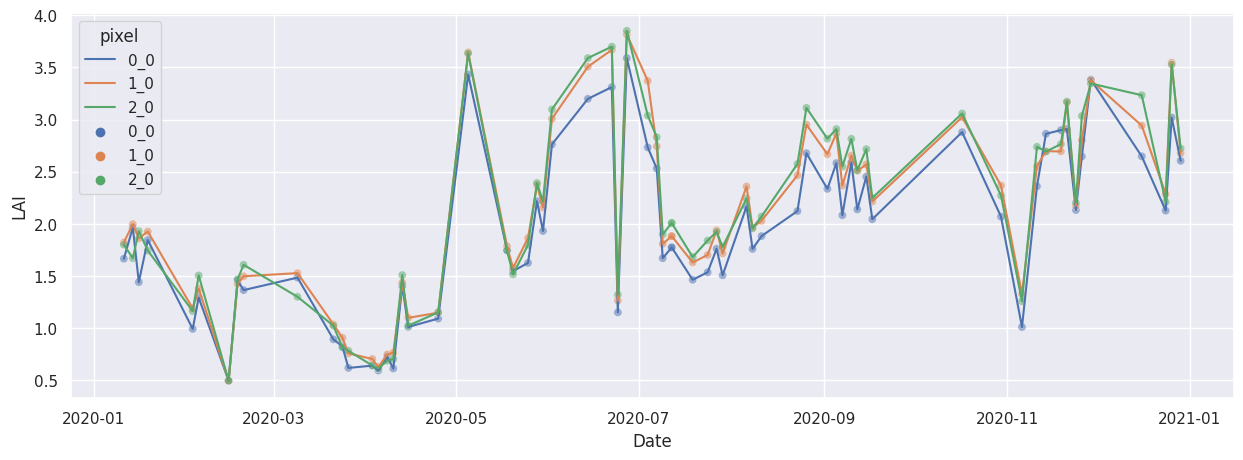

In [135]:
view = df.iloc[:,i:i+3]

# Expand the data into long format with date, lai, and patchlet as columns
dfns = view.stack().reset_index()
dfns.columns = ["date", "pixel", "LAI"]

# Plot the time series with seaborn, with dots at each observation
fig, ax = plt.subplots(figsize=(15, 5))
sns.set_theme(style="darkgrid")
ax = sns.lineplot(data=dfns, x="date", y="LAI", hue="pixel", ax=ax, ci=None)
ax = sns.scatterplot(data=dfns, x="date", y="LAI", hue="pixel", ax=ax, alpha=0.5)

ax.set_xlabel("Date")

plt.show()

## Field timeseries

In [136]:
df = pd.read_csv("/home/jens/ownCloud/Documents/3.Werk/0.TUe_Research/0.STELAR/0.VISTA/VISTA_workbench/data/pipeline_example/lai_field_timeseries.csv")

df

,Unnamed: 0,0,3,4,5,6,7,8,9,10,...,91986,91987,91988,91989,91990,91991,91992,91993,91994,91996
0,2021-07-17,928.0,5310.0,2698.0,292.0,244.5,3438.0,289.0,3688.0,3528.0,...,3474.0,5650.0,NaN,5452.0,4390.0,5400.0,727.0,5616.0,3134.0,1734.0
1,2021-07-19,638.0,4780.0,2724.0,253.5,247.0,3124.0,257.0,3416.0,3326.0,...,3492.0,5220.0,NaN,4916.0,4130.0,4996.0,552.0,5188.0,2912.0,1575.0
2,2021-07-22,808.0,4910.0,2634.0,301.0,566.0,3066.0,366.0,3300.0,3162.0,...,2496.0,3058.0,NaN,3728.0,3538.0,1462.0,1019.0,2822.0,2510.0,1811.0
3,2021-07-24,NaN,NaN,NaN,287.0,560.5,NaN,NaN,NaN,NaN,...,NaN,3746.0,NaN,NaN,NaN,NaN,346.0,NaN,2280.0,3250.0
4,2021-08-08,NaN,2844.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3252.0,NaN,NaN,NaN,2796.0,399.0,5000.0,1872.0,1744.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,2020-03-26,1922.0,518.0,350.5,240.0,159.5,3356.0,2272.0,1444.0,3186.0,...,NaN,NaN,NaN,NaN,396.0,1000.0,4460.0,NaN,2044.0,1286.0
262,2020-03-31,1636.0,660.0,460.5,426.0,243.5,3076.0,1760.0,1308.0,2892.0,...,4852.0,1295.0,4700.0,296.5,875.0,2462.0,NaN,1606.0,3310.0,3204.0
263,2020-04-03,1534.0,360.0,308.0,182.0,136.5,3148.0,2092.0,1351.0,3064.0,...,5056.0,1538.0,5096.0,287.0,527.0,2326.0,5664.0,3036.0,3538.0,3044.0
264,2020-04-05,1477.0,232.0,246.5,187.0,126.5,2968.0,2027.0,1284.0,2916.0,...,NaN,1494.0,5040.0,283.0,460.0,2440.0,5612.0,1656.0,3492.0,2884.0


### 1. Field image over time

In [82]:
# Get the LAI eopatch of patchlet 4,3
path = os.path.join(LOCAL_DATADIR, "patchlets", "patchlet_4_3")
eop = EOPatch.load(path)

eop

EOPatch(
  data: {
    LAI: numpy.ndarray(shape=(87, 1128, 1128, 1), dtype=int16)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((749975.0, 4950025.0), (761255.0, 4961305.0)), crs=CRS('32630'))
  timestamp: [datetime.datetime(2020, 1, 6, 0, 0), ..., datetime.datetime(2020, 12, 29, 0, 0)], length=87
)

In [83]:
lai = eop.data["LAI"]

# Get the percentage of positive values over time
lai_pos = (lai > 0).mean(axis=(1, 2))

# Make into dataframe with date as index
lai_pos_df = pd.DataFrame(np.array([eop.timestamp, lai_pos.squeeze()]).T, columns=["datetime", "LAI"])

lai_pos_df

,datetime,LAI
0,2020-01-06,0.0
1,2020-01-11,0.97529
2,2020-01-14,0.983446
3,2020-01-16,0.981964
4,2020-01-19,0.984173
...,...,...
82,2020-12-06,0.127922
83,2020-12-16,0.929523
84,2020-12-24,0.441309
85,2020-12-26,0.960023


In [84]:
# For each month, get the date with the highest percentage of positive values
dts = []
for i in range(1, 13):
    dt = lai_pos_df.loc[lai_pos_df.datetime.dt.month == i].sort_values(by="LAI", ascending=False)["datetime"].iloc[0]
    dts.append(dt)

dts

[Timestamp('2020-01-19 00:00:00'),
 Timestamp('2020-02-20 00:00:00'),
 Timestamp('2020-03-21 00:00:00'),
 Timestamp('2020-04-13 00:00:00'),
 Timestamp('2020-05-18 00:00:00'),
 Timestamp('2020-06-27 00:00:00'),
 Timestamp('2020-07-09 00:00:00'),
 Timestamp('2020-08-11 00:00:00'),
 Timestamp('2020-09-17 00:00:00'),
 Timestamp('2020-10-30 00:00:00'),
 Timestamp('2020-11-24 00:00:00'),
 Timestamp('2020-12-26 00:00:00')]

In [115]:
counts = lai_pos_df.groupby(lai_pos_df.datetime.dt.month).LAI.count()

counts

datetime
1      5
2      6
3      6
4      8
5      9
6      8
7      9
8      8
9      8
10     4
11    11
12     5
Name: LAI, dtype: int64

In [90]:
# Make mask array for dts on timestamps
dts_mask = np.isin(eop.timestamp, dts)

dts_mask

array([False, False, False, False,  True, False, False, False, False,
       False,  True, False, False,  True, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False,  True, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False,  True, False])

In [85]:
from stelar_spatiotemporal.lib import export_eopatch_to_tiff
from stelar_spatiotemporal.eolearn.core import EOPatch, FeatureType, OverwritePermission

outpath = os.path.join(TMPDIR, "plot_eop_4_3.tiff")

# export to tiff
export_eopatch_to_tiff(eop_path=path,
                       out_path=outpath,
                        feature=(FeatureType.DATA, "LAI"))


In [86]:
import rasterio

# Read the tiff file
src = rasterio.open(outpath)

src.meta

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': 0.0,
 'width': 1128,
 'height': 1128,
 'count': 87,
 'crs': CRS.from_epsg(32630),
 'transform': Affine(10.0, 0.0, 749975.0,
        0.0, -10.0, 4961305.0)}

In [16]:
from stelar_spatiotemporal.preprocessing.timeseries import load_fields

# Get all fields
fields_path = os.path.join(LOCAL_DATADIR, "fields", "fields.gpkg")
fields = load_fields(fields_path, min_area=1000, max_area=10000)

fields

,geometry
0,"POLYGON ((708936.250 4901425.950, 708933.750 4..."
1,"POLYGON ((707173.750 4902273.017, 707175.870 4..."
2,"POLYGON ((706888.750 4905373.936, 706886.250 4..."
3,"POLYGON ((704880.283 4913578.750, 704878.868 4..."
4,"POLYGON ((705159.993 4915188.750, 705159.993 4..."
...,...
35618,"POLYGON ((802508.750 4991682.236, 802506.250 4..."
35619,"POLYGON ((803426.250 4992515.272, 803427.962 4..."
35620,"POLYGON ((803268.750 4992499.856, 803266.250 4..."
35621,"POLYGON ((803150.958 4992681.250, 803151.250 4..."


In [21]:
# Create shape from eop bbox
from shapely.geometry import box
eop_bbox = box(*eop.bbox)

# Filter the fields that fill within the bbox of the eopatch
patch_fields = fields.loc[fields.intersects(eop_bbox)]

# Sort by area
patch_fields['area'] = patch_fields.area
patch_fields.sort_values(by="area", ascending=False, inplace=True)

patch_fields

/home/jens/ownCloud/Documents/3.Werk/0.TUe_Research/0.STELAR/0.VISTA/VISTA_workbench/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/tmp/ipykernel_3019347/1871548848.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patch_fields.sort_values(by="area", ascending=False, inplace=True)


,geometry,area
18708,"POLYGON ((758993.750 4956236.850, 758995.017 4...",9999.401140
18002,"POLYGON ((756950.238 4953933.750, 756951.250 4...",9968.681450
18359,"POLYGON ((758041.394 4956886.250, 758042.130 4...",9922.213714
16627,"POLYGON ((753198.750 4957024.858, 753201.250 4...",9877.372953
16230,"POLYGON ((752021.250 4950468.017, 752023.750 4...",9823.946461
...,...,...
17327,"POLYGON ((754645.309 4955883.750, 754646.250 4...",1025.952019
16633,"POLYGON ((752841.250 4958403.746, 752843.750 4...",1018.030348
18004,"POLYGON ((757261.779 4955081.250, 757263.750 4...",1017.694535
15504,"POLYGON ((750758.750 4959507.913, 750761.250 4...",1017.008487


In [87]:
from stelar_spatiotemporal.preprocessing.timeseries import mask_field

# Get the next field
field = patch_fields.iloc[1].geometry

mask = mask_field(field,src)

mask.shape

(87, 13, 15)

In [91]:
# Take only the selected field
filt_mask = mask[dts_mask]

filt_mask.shape

(12, 13, 15)

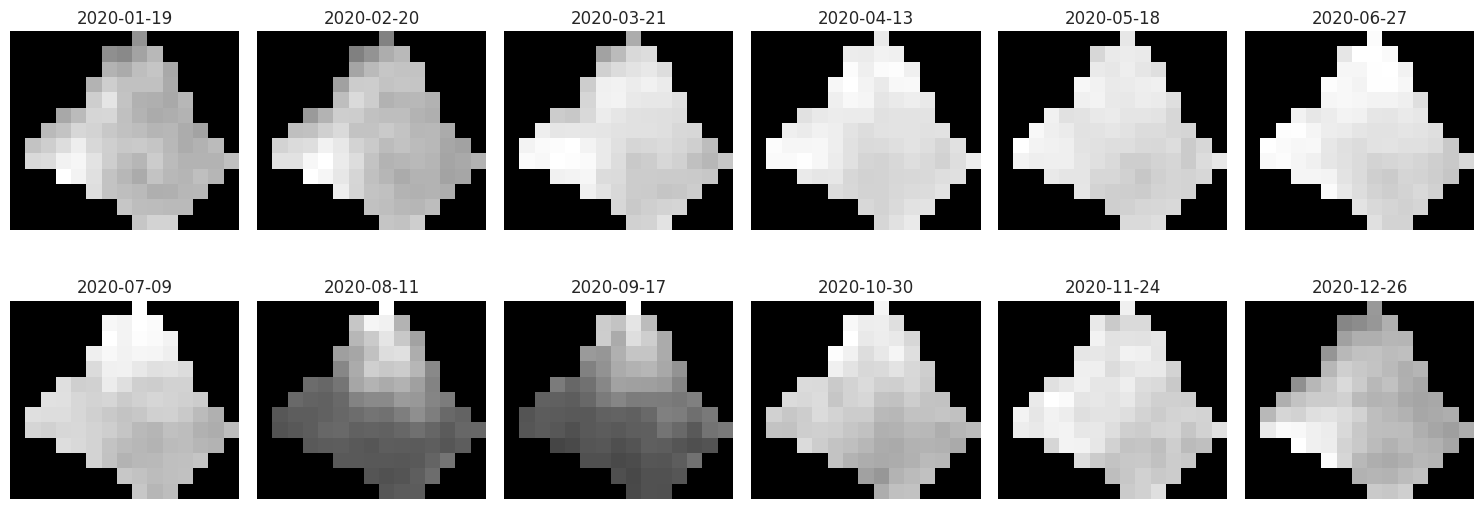

In [92]:
# Plot the field over time
n = filt_mask.shape[0]
nrows = 2
ncols = n//nrows
fig,axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 3*nrows))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(filt_mask[i], cmap="gray")
    ax.set_title(dts[i].date())
    ax.axis("off")

plt.tight_layout()

plt.show()

In [102]:
px_ts = mask.reshape(mask.shape[0], -1).T

# Filter rows with no data
px_ts = px_ts[px_ts.sum(axis=1) > 0].astype(float)

px_ts[px_ts <= 0] = np.nan

# Get field ts through nanmedian
field_ts = np.nanmedian(px_ts, axis=0)

px_ts, field_ts

/home/jens/ownCloud/Documents/3.Werk/0.TUe_Research/0.STELAR/0.VISTA/VISTA_workbench/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


(array([[  nan, 1631., 1620., ...,   nan, 2352.,   nan],
        [  nan, 1625., 1734., ...,   nan, 2071.,   nan],
        [  nan, 1539., 1865., ...,   nan, 2158.,   nan],
        ...,
        [  nan, 2176., 2119., ...,   nan, 3101.,   nan],
        [  nan, 2176., 2244., ...,   nan, 3055.,   nan],
        [  nan, 2302., 2381., ...,   nan, 3181.,   nan]]),
 array([   nan, 2100. , 2083. , 1986. , 2306. , 1945. , 2531. ,    nan,
         659. , 2445. , 2682. ,    nan, 2697. , 3306. , 3635. ,    nan,
        2440. , 3193. , 3191. , 3199. , 3185. , 3298. , 3240. , 3501. ,
        2113. , 1724. , 3688. , 3524. , 3629. , 3778. , 3598. , 3638. ,
        3833. , 3678. ,    nan, 1853.5, 4449. ,    nan, 3448. , 2396. ,
        4804. ,    nan, 4471. , 4721. , 3743. , 3919. , 3680. , 3244. ,
        2538. , 2255. , 1882. ,    nan, 1652. ,    nan, 1276. ,    nan,
           nan,    nan, 1331. , 1387. , 1264. , 1186. , 1109. , 1091. ,
        1037. , 1033. , 1654. , 2655. , 2867. , 2900. , 3308. ,    

In [112]:
nan_p = np.isnan(px_ts).mean(axis=0)
(nan_p < 1) & (nan_p > .95)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

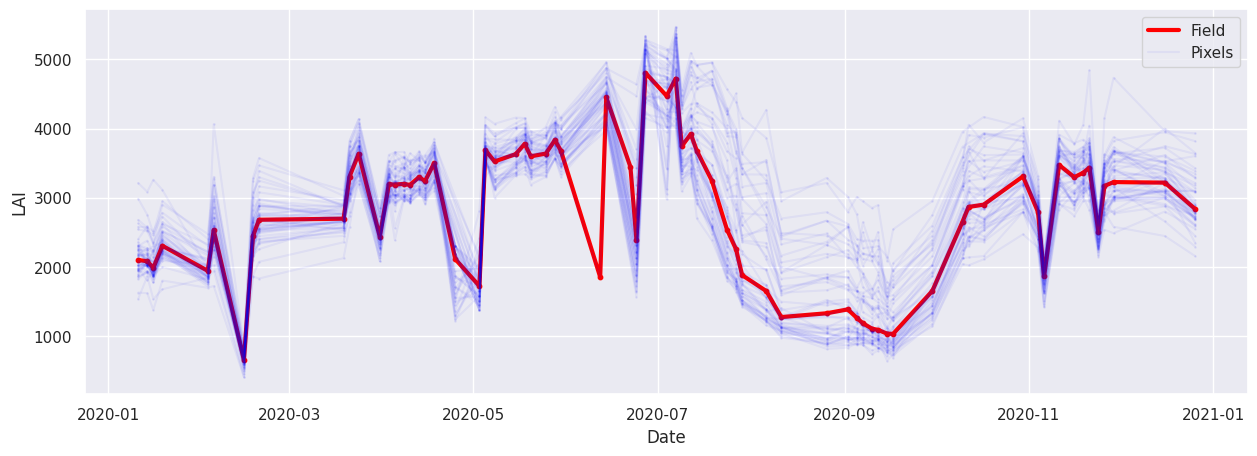

In [107]:
# Plot both pixels (with alpha) and the field time series over time
fig, ax = plt.subplots(figsize=(15, 5))

nan_filter = np.isnan(field_ts)
field_ts_vals = field_ts[~nan_filter]
field_ts_time = np.array(eop.timestamp)[~nan_filter]

ax.plot(field_ts_time, field_ts_vals, color="red", label="Field", linewidth=3)
ax.scatter(field_ts_time, field_ts_vals, color="red", s=10)

srate = 2
px_alpha = 0.05

for i in range(0,px_ts.shape[0],srate):
    nan_filter = np.isnan(px_ts[i])

    px_ts_i = px_ts[i][~nan_filter]
    px_ts_ts = np.array(eop.timestamp)[~nan_filter]

    if i == 0:
        ax.plot(px_ts_ts, px_ts_i, alpha=px_alpha, color="blue", label=f"Pixels")
    else:
        ax.plot(px_ts_ts, px_ts_i, alpha=px_alpha, color="blue")
    ax.scatter(px_ts_ts, px_ts_i, alpha=px_alpha, color="blue", s=1)

ax.set_xlabel("Date")
ax.set_ylabel("LAI")
ax.legend()


[datetime.datetime(2020, 1, 6, 0, 0),
 datetime.datetime(2020, 1, 11, 0, 0),
 datetime.datetime(2020, 1, 14, 0, 0),
 datetime.datetime(2020, 1, 16, 0, 0),
 datetime.datetime(2020, 1, 19, 0, 0),
 datetime.datetime(2020, 2, 3, 0, 0),
 datetime.datetime(2020, 2, 5, 0, 0),
 datetime.datetime(2020, 2, 8, 0, 0),
 datetime.datetime(2020, 2, 15, 0, 0),
 datetime.datetime(2020, 2, 18, 0, 0),
 datetime.datetime(2020, 2, 20, 0, 0),
 datetime.datetime(2020, 3, 9, 0, 0),
 datetime.datetime(2020, 3, 19, 0, 0),
 datetime.datetime(2020, 3, 21, 0, 0),
 datetime.datetime(2020, 3, 24, 0, 0),
 datetime.datetime(2020, 3, 26, 0, 0),
 datetime.datetime(2020, 3, 31, 0, 0),
 datetime.datetime(2020, 4, 3, 0, 0),
 datetime.datetime(2020, 4, 5, 0, 0),
 datetime.datetime(2020, 4, 8, 0, 0),
 datetime.datetime(2020, 4, 10, 0, 0),
 datetime.datetime(2020, 4, 13, 0, 0),
 datetime.datetime(2020, 4, 15, 0, 0),
 datetime.datetime(2020, 4, 18, 0, 0),
 datetime.datetime(2020, 4, 25, 0, 0),
 datetime.datetime(2020, 5, 3, 0,